# OOF  
test  
out of fold 안에 k-fold cross validation이 있음  
ex) k-fold cross validation : 데이터 수가 적어 모델이 오버피팅 가능성이 있을때 이를 예방하기 위하여 사용하는 교차검증 방법   
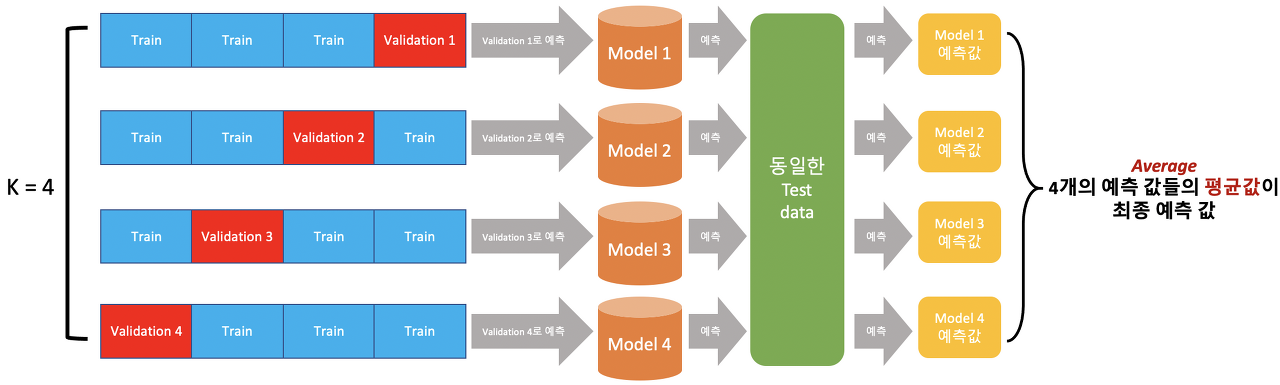

In [4]:
import numpy as np
import pandas as pd
import urllib.request
import tensorflow as tf


urllib.request.urlretrieve("https://raw.githubusercontent.com/LDJWJ/kagglebook/main/input/sample-data/train_preprocessed.csv",
                          filename = 'train_preprocessed.csv')
urllib.request.urlretrieve("https://raw.githubusercontent.com/LDJWJ/kagglebook/main/input/sample-data/test_preprocessed.csv",
                          filename = 'test_preprocessed.csv')
urllib.request.urlretrieve("https://raw.githubusercontent.com/LDJWJ/kagglebook/main/input/sample-data/train_preprocessed_onehot.csv",
                          filename = 'train_preprocessed_onehot.csv')
urllib.request.urlretrieve("https://raw.githubusercontent.com/LDJWJ/kagglebook/main/input/sample-data/test_preprocessed_onehot.csv",
                          filename = 'test_preprocessed_onehot.csv')

train = pd.read_csv('train_preprocessed.csv')
train_x = train.drop(['target'], axis = 1)
train_y = train['target']
test_x = pd.read_csv('test_preprocessed.csv')

train_nn = pd.read_csv('train_preprocessed_onehot.csv')
train_x_nn = train_nn.drop(['target'], axis=1)
train_y_nn = train_nn['target']
test_x_nn = pd.read_csv('test_preprocessed_onehot.csv')

In [18]:
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold

from kmodels import Model1Xgb, Model1NN, Model2Linear

def predict_cv(model, train_x, train_y, test_x):
    preds = []
    preds_test = []
    va_idxes = []
    
    kf = KFold(n_splits=4, shuffle = True, random_state = 71)
    
    for i, (tr_idx, va_idx) in enumerate(kf.split(train_x)):
        # 원래 kf.split(train)의 output은 train_idx, validation_idx
        # i는 i번째 fold를 의미
        tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
        tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
        # 왜 iloc일까 iloc은 행번호인데 index 번호가 아니라
        model.fit(tr_x, tr_y, va_x, va_y)
        pred = model.predict(va_x)
        preds.append(pred)
        pred_test = model.predict(test_x)
        preds_test.append(pred_test)
        va_idxes.append(va_idx)
        
    va_idxes = np.concatenate(va_idxes)
    # concatenate 하기 전에는 [[1,2,3,4],[5,6,7,8]] 였을것
    # concatenate 하면 아래처럼 하나의 array
    # [1,2,3,4,5,6,7,8]
    preds = np.concatenate(preds, axis = 0) # 위 아래로 연결
    order = np.argsort(va_idxes) #value에 따른 정렬
    pred_train = preds[order]
    
    preds_test = np.mean(preds_test, axis = 0)
    return pred_train, preds_test

model_1a = Model1Xgb()
pred_train_1a, pred_test_1a = predict_cv(model_1a, train_x, train_y, test_x)

model_1b = Model1NN()
pred_train_1b, pred_test_1b = predict_cv(model_1b, train_x_nn, train_y, test_x_nn)

print(f'logloss: {log_loss(train_y, pred_train_1a, eps = 1e-7):.4f}')
print(f'logloss: {log_loss(train_y, pred_train_1b, eps = 1e-7):.4f}')
#f'str {~ :옵션}' 

# 사전적 의미의 앙상블은 이부분
train_x_2 = pd.DataFrame({'pred_1a':pred_train_1a, 'pred_1b':pred_train_1b})
test_x_2 = pd.DataFrame({'pred_1a': pred_test_1a, 'pred_1b': pred_test_1b})

model_2 = Model2Linear()
pred_train_2, pred_test_2 = predict_cv(model_2, train_x_2, train_y, test_x_2)
print(f'logloss: {log_loss(train_y, pred_train_2, eps = 1e-7):.4f}')
# print(f'logloss: {log_loss(test_y, pred_test_2, eps = 1e-7):.4f}')
# 위는 불가 test_y가 없음

[20:54:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-logloss:0.54088	eval-logloss:0.55003
[1]	train-logloss:0.45269	eval-logloss:0.47182
[2]	train-logloss:0.39482	eval-logloss:0.42026
[3]	train-logloss:0.35198	eval-logloss:0.38520
[4]	train-logloss:0.32021	eval-logloss:0.36150
[5]	train-logloss:0.29673	eval-logloss:0.34463
[6]	train-logloss:0.27610	eval-logloss:0.32900
[7]	train-logloss:0.25886	eval-logloss:0.31670
[8]	train-logloss:0.24363	eval-logloss:0.30775
[9]	train-logloss:0.23153	eval-logloss:0.30092
[20:54:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are

In [16]:
train_x_2

,pred_1a,pred_1b
0,0.052786,0.018606
1,0.189076,0.003749
2,0.431136,0.374959
3,0.042489,0.007111
4,0.256559,0.503394
...,...,...
9995,0.080526,0.139624
9996,0.217642,0.278892
9997,0.089406,0.002393
9998,0.044032,0.010244


In [19]:
print(np.array(0.5))

0.5
